# Tutorial 27: Modeling data with least-squares fitting

## PHYS 2600, Spring 2019

In [1]:
# Import cell
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import gvar as gv
import lsqfit


## T27.1 - Getting started with `lsqfit`

As usual, there are a lot of available modules that can help us carry out least-squares modeling in Python - for example, the `scipy.optimize.curve_fit` function can do general non-linear least squares.

We're going to learn a different module called `lsqfit` - you can find [the documentation here](https://lsqfit.readthedocs.io/en/latest/).  The `lsqfit` module is something I use in research often: it is more general and powerful than the `scipy` curve fitter, and it works natively with the `gvar` module (both are from the same author.)

To warm up, we'll start with a simple linear fit to some [real data taken from a teaching photoelectric effect experiment](http://www.phys.ncku.edu.tw/~cctsai/teaching/10102/IntModernPhysics/Duarte_photoelectric.pdf).  Here are the data points:

| f [$\times 10^{14}$ Hz] | $V_{\rm stop}$ [V] |
|-------------------------|--------------------|
| 5.490 | 0.24(4) |
| 6.879 | 0.80(10) |
| 7.408 | 1.20(20) |
| 8.213 | 1.50(25) |

I've also provided the data in the cell below, along with a quick function that makes an errorbar plot of gvar data.  __Run the cell to load the data variables and make a plot.__

Text(0, 0.5, '$V_{\\rm stop} [V]$')

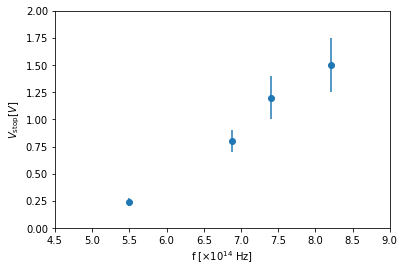

In [2]:
f = np.array([5.490, 6.879, 7.408, 8.213]) # 10^{14} Hz
Vcut = gv.gvar(['0.24(4)', '0.80(10)', '1.20(20)', '1.50(25)']) # V

def plot_gvar(x, y_gv):
    """
    Given two arrays of equal length, one of which contains
    gvar objects, returns an errorbar plot of y(x).
    
    Arguments:
    ====
    x: Array of x-values.
    y_gv: Array of y-values with error [as gvars.]
    
    Returns:
    =====
    An errorbar plot.
    """
    
    return plt.errorbar(x, gv.mean(y_gv), yerr=gv.sdev(y_gv), linestyle='', marker='o')
    
    
plot_gvar(f, Vcut)
plt.xlim(4.5, 9.0)
plt.ylim(0,2)
plt.xlabel('f [$\\times 10^{14}$ Hz]')
plt.ylabel('$V_{\\rm stop} [V]$')

We expect a linear relationship between the light frequency $f$ and the stopping voltage $V_{\rm stop}$ - looks plausible, although the data are a bit noisy.  To test the linear model and get the work function and Planck's constant, we need to set up a fit!

The fist thing we'll need is a model function.  It turns out that `lsqfit` wants this to be implemented as a Python function.  __Implement the function `PE_model(f, a)` below__, where `f` should be an array of frequency values and `a` is an array of fit parameters (in whatever order we want, defined by the function itself.)  The model function we want to use is:

$$
eV_{\rm stop} = hf - \Phi
$$

so the parameter vector is $\mathbf{a} = (h, \Phi)$.


In [3]:
def PE_model(f, a):    
    ### BEGIN SOLUTION
    return a[0] * f - a[1]
    ### END SOLUTION
    



In [4]:
import numpy.testing as npt

npt.assert_allclose(PE_model(5, [1,1]), 4)
npt.assert_allclose(PE_model(f, [0,0]), [0, 0, 0, 0])
npt.assert_allclose(PE_model(f, [1,1]), [4.49, 5.879, 6.408, 7.213])

Now use your function `PE_model` to make a plot showing the data (copy from the cell above) as well as the model, using a guess for the fit parameters of `(h, Phi) = (0.5, 3)` (which I came up with by staring at the plot - maybe you can do better?)

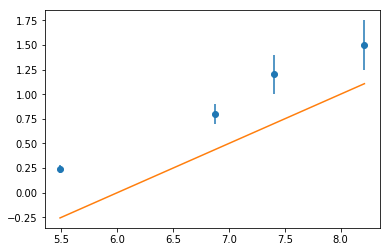

In [6]:
a0 = [0.5,3]

### BEGIN SOLUTION
plot_gvar(f, Vcut)
plt.plot(f, PE_model(f, a0))
### END SOLUTION

Finally, let's actually run the fitter and find the best fit!  The main workhorse function of `lsqfit` is called `lsqfit.nonlinear_fit()`.  (Yes, even though this is a linear fit, we can use this function - linear fits are a special case so it will still work.)  The documentation for `lsqfit.nonlinear_fit()` is pretty complicated, because it has a lot of features.  But recalling the definition of $\chi^2$,

$$
\chi^2 = \sum_i \left(\frac{y_i - f(x_i, \mathbf{a})}{\sigma_i} \right)^2,
$$

we expect that `lsqfit.nonlinear_fit` must take the following arguments at least:

* Data for independent variable(s), $x_i$;
* Data for dependent variable(s), $y_i$, and error bars $\sigma_i$;
* The model function $f$.

It will also need an __initial guess__, $\mathbf{a}_0$, because the methods it uses to minimize the $\chi^2$ function require a starting point.  (Having a good initial guess can often greatly improve the speed and accuracy of a nonlinear fit!)  Once we have our data `x` and `y`, model function `f`, and initial guess `a0`, the call signature is:

```
fit_result = lsqfit.nonlinear_fit(data=(x,y), fcn=f, p0=a0)
```

This will run the fit and return an object containing lots of information.  __Call the `nonlinear_fit` function below__, using the variables you defined above and the initial guess `a0=[0.5,3]` that we plotted just above.  Then __print the object returned by `nonlinear_fit`__ (I like to call it "`fit_result`") to see a report on the best fit!

In [7]:
fit_result = lsqfit.nonlinear_fit(data=(f,Vcut), fcn=PE_model, p0=a0)
print(fit_result)

Least Square Fit (no prior):
  chi2/dof [dof] = 0.33 [2]    Q = 0.72    

Parameters:
              0   0.445 (55)     [ 0.5 +- inf ]  
              1    2.20 (32)     [   3 +- inf ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10*,1e-10)    (itns/time = 2/0.0)
  fitter = scipy_least_squares    method = trf



There's lots of information to unpack there.  The most important features in the report are:

* At the top, the reduced $\chi^2 / N_{\rm dof}$, following by $N_{\rm dof}$ in square brackets.  Finally, the quantity $Q$ is the p-value of the fit: the probability that we would draw the given experimental data if the best-fit model is true.  (This should be a good fit: reduced $\chi^2$ should be smaller than 1, and $Q$ should be pretty large.)
* Under the heading "Parameters:" on the left, the best-fit value with error bar for each parameter.  On the right, the initial values of each parameter.  (The "error bar" on our initial guess is infinity, because our guess had no error.  If we had __prior information__ about one or more parameters, we could impose that as a prior constraint on the fit, one of `lsqfit`'s advanced features.)

The information under "Settings:" mostly has to do with the internal workings of the fitter, and can be safely ignored unless you are running into numerical problems with doing the fit itself.

Note that although calling `print(fit_result)` gives us a nice text-formatted report, `fit_result` itself is actually an object that contains other information in the form of properties (accessed with `.` notation.)  In the cell below, __try accessing the following properties__:

* `fit_result.chi2`: Un-reduced value of $\chi^2$ at best-fit point.
* `fit_result.dof`: The number of degrees of freedom.
* `fit_result.p`: Array of best-fit parameters as gvars.
* `fit_result.x` and `fit_result.y`: The data used in the fit.  (Often useful to use later!)

Make and plot an array of __fit residuals__, $r_i = y_i - f(x_i, \mathbf{a})$, evaluated with the best-fit parameters.  (You may want to normalize by the error bars $y_i$, which you can access using `gv.sdev()` - but the plot will look similar without the normalization.)




0.6509595574830891
2
[0.445(55) 2.20(32)]
[5.49  6.879 7.408 8.213] [0.240(40) 0.80(10) 1.20(20) 1.50(25)]
[0.07(12) -0.55(72) 0.55(88) 0.21(84)]


<ErrorbarContainer object of 3 artists>

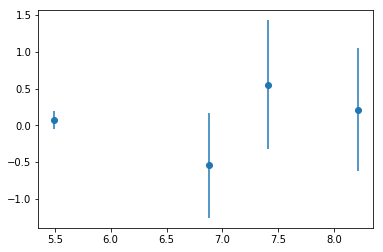

In [8]:
print(fit_result.chi2)
print(fit_result.dof)
print(fit_result.p)
print(fit_result.x, fit_result.y)

resids = (fit_result.y - PE_model(fit_result.x, fit_result.p)) / gv.sdev(fit_result.y)
print(resids)
plot_gvar(f, resids)

Next, __convert your fit results to an estimate for Planck's constant__.  By working in volts we've been implicitly dividing everything by the electron charge $e = 1.602 \times 10^{-19}$ C, so you'll need to multiply the parameters through by that.  Don't forget to account for the factor of $10^{14}$ we pulled out of the frequency data!  The real value is

$$
h = 6.626 \times 10^{-34}\ \rm{J} \cdot \rm{s}
$$

How close is your result?  Is the more precise value of $h$ within the error bar of your estimate?

Using `fit_result.p`, calculate the ratio of your two model parameters, i.e. calculate $\Phi / h$.  Not worrying about units or the $10^{14}$, if I go back to the fit itself and take the ratio with standard error propagation, I find `4.96(94)`.  But if you use `fit_result.p`, __the error on the ratio should be much smaller.__ Why?

In [9]:
print(fit_result.p[0] * 1.602e-19 * 1e-14)
print(fit_result.p[1] / fit_result.p[0])
print(gv.corr(fit_result.p[0], fit_result.p[1]))  
# fit_result.p knows about the large correlation between phi and h!

7.12(88)e-34
4.96(13)
0.9935569965627223


Finally, implement the two alternative models, constant and quadratic:

$$
eV_{\rm stop} = C \\
eV_{\rm stop} = kf^2 - \Phi
$$

Run the nonlinear fits for both cases against the same data.  How do the p-values ("Q"-values) compare to the linear model?  Can you reject either or both alternative models based on this data set?

In [10]:
### BEGIN SOLUTION
def const_model(f, a):
    return a[0]

def quad_model(f, a):
    return a[0] * f**2 - a[1]
    
fr_const = lsqfit.nonlinear_fit(data=(f,Vcut), fcn=const_model, p0=[1])
print(fr_const)

fr_quad = lsqfit.nonlinear_fit(data=(f,Vcut), fcn=quad_model, p0=[1,1])
print(fr_quad)


## Reject the constant model: p-value is very small, close to zero.
## Can't reject the quadratic model, at least with this data set!
## (Of course, there are many other photoelectric experiments out there:
## we know that the linear model is the correct one.)

### END SOLUTION

Least Square Fit (no prior):
  chi2/dof [dof] = 22 [3]    Q = 2.2e-14    

Parameters:
              0   0.371 (36)     [   1 +- inf ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10*,1e-10)    (itns/time = 2/0.0)
  fitter = scipy_least_squares    method = trf

Least Square Fit (no prior):
  chi2/dof [dof] = 0.2 [2]    Q = 0.82    

Parameters:
              0   0.0345 (42)     [   1 +- inf ]  
              1     0.80 (15)     [   1 +- inf ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10*,1e-10)    (itns/time = 3/0.0)
  fitter = scipy_least_squares    method = trf



## T27.2 - Fitting to exponential decay

The first exercise was a nice introduction, but linear fits are really easy: they're safe from a lot of the problems that can appear in more general non-linear fits.  Let's step up the difficulty and try to fit an _exponential decay_.

The cell below reads in a sequence of random decays - actually, they're generated using the Monte Carlo for radioactive decay from tutorial 22.  The data consists of time (in seconds) and a set of particle counts from repeated trials.  As a reminder, our model for the expected number of particles remaining is:

$$
N(t) = N_0 e^{-t/\tau}.
$$

We have a partial sample of the data, running from 10 to 25 seconds, so we'll need to fit to determine both the size of the initial sample $N_0$ and the lifetime $\tau$.

First, __run the cell below__ to import the data and plot it.  (The data file isn't _too_ complicated, but it might be time-consuming to set up so I've provided the code.)

[376.6(2.2) 342.0(1.9) 309.7(1.9) 281.3(1.7) 254.6(1.7) 231.8(1.7)
 211.3(1.7) 191.4(1.8) 172.9(1.7) 156.9(1.7) 142.8(1.5) 129.8(1.6)
 117.8(1.5) 106.5(1.3) 96.0(1.3)]


<ErrorbarContainer object of 3 artists>

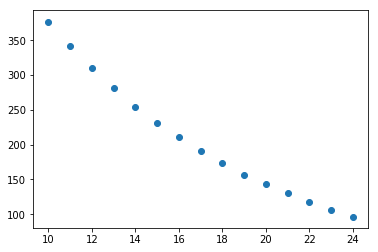

In [11]:
ds = np.genfromtxt('decay_one_dataset.csv')
t_data = ds[:,0]
decay_data = gv.dataset.avg_data(ds[:,1:].T)
print(decay_data)
plot_gvar(t_data, decay_data)

Now write a fit model function, then __run the nonlinear fit__ with initial guess $500$ for the initial abundance and $1$ for the lifetime.

In [15]:
def fcn_exp_one(t, a):
    return a[0] * np.exp(- t / a[1])

# My mistake, you actually need 1000 for the initial abundance to see this go wrong!
f1 = lsqfit.nonlinear_fit(data=(t_data, decay_data), fcn=fcn_exp_one, p0=[1000.0, 1.])
print(f1)

Least Square Fit (no prior):
  chi2/dof [dof] = 2.8e+03 [13]    Q = 0    

Parameters:
              0                98.7 (1.1)           [ 1000 +- inf ]  
              1   -3.40787e+10 +- 2.2e-18           [    1 +- inf ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 53/0.0)
  fitter = scipy_least_squares    method = trf



You should find that your model is an extremely poor description of the data!  This doesn't mean your model function is wrong; it's actually a symptom of numerical instability, which exponential functions are notorious for.  __Try the fit again in the cell below__, changing the initial guess to 10.

In [16]:
f1 = lsqfit.nonlinear_fit(data=(t_data, decay_data), fcn=fcn_exp_one, p0=[1000.0, 10.])
print(f1)

Least Square Fit (no prior):
  chi2/dof [dof] = 0.85 [13]    Q = 0.61    

Parameters:
              0   995.5 (7.2)     [ 1000 +- inf ]  
              1   10.283 (66)     [   10 +- inf ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 5/0.0)
  fitter = scipy_least_squares    method = trf



This is from our model of nitrogen-16, so the correct lifetime is 10.286 seconds and the correct initial sample size was 1000 particles.  Hopefully your fit now agrees with those values and has a good p-value!

The numerical instability here is due to the fact that our fitter can end up exploring a region where $\tau$ is negative, where the model starts to diverge rapidly.  But we know that this is an __unphysical region__; the lifetime can't really be negative!  Fortunately, there's a nice trick we can use.  We re-map our model variables slightly, to

$$
N(t) = N_0 e^{-t/e^{\lambda}}
$$

which is just our original model if we identify

$$
\lambda = \log \tau.
$$

But now since we have the exponential, no matter what value $\lambda$ takes, $\tau$ is __always positive__!

__Write a re-mapped model function below__, then re-try the fit with a _bad_ initial guess (or multiple bad guesses) and see how the convergence to the right answer has improved.

In [17]:
def fcn_exp_one_map(t, a):
    return a[0] * np.exp(- t / np.exp(a[1]))

f1 = lsqfit.nonlinear_fit(data=(t_data, decay_data), fcn=fcn_exp_one_map, p0=[1.0, np.log(1.)])
print(f1)
print(np.exp(f1.p[1]))

Least Square Fit (no prior):
  chi2/dof [dof] = 0.85 [13]    Q = 0.61    

Parameters:
              0   995.5 (7.2)     [   1 +- inf ]  
              1   2.3305 (64)     [   0 +- inf ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 57/0.0)
  fitter = scipy_least_squares    method = trf

10.283(66)


### Optional challenge

I included another file `decay_two_dataset.csv`, which contains data generated from a model which is a _sum_ of two exponentials,

$$
N(t) = N_1 e^{-t/\tau_1} + N_2 e^{-t/\tau_2}
$$

This is a notoriously hard problem in nonlinear model fitting.  Can you fit the data and get both lifetimes?

[491.1(2.3) 436.2(2.2) 390.3(2.1) 350.7(2.1) 314.5(2.1) 281.6(2.1)
 253.6(2.1) 228.1(2.0) 204.2(1.8) 184.4(1.6) 166.7(1.5) 150.0(1.4)
 134.4(1.4) 121.3(1.4) 109.8(1.4)]
Least Square Fit (no prior):
  chi2/dof [dof] = 1.3 [11]    Q = 0.24    

Parameters:
              0   13.7 (3.5)     [  8.00637 +- inf ]  
              1   -0.14 (32)     [  2.25129 +- inf ]  
              2   7.234 (11)     [  6.90776 +- inf ]  
              3   2.149 (31)     [ 0.693147 +- inf ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 37/0.0)
  fitter = scipy_least_squares    method = trf

923389(3259238) 1385(15) 0.87(28) 9.446(67)


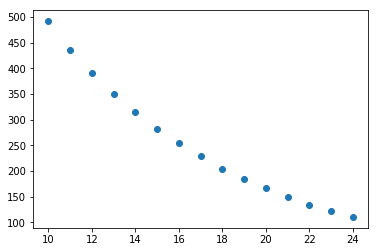

In [62]:
ds2 = np.genfromtxt('decay_two_dataset.csv')
t_data = ds2[:,0]
decay_data_2 = gv.dataset.avg_data(ds2[:,1:].T)
print(decay_data_2)
plot_gvar(t_data, decay_data_2)

# Looks similar...

def fcn_exp_two_map(t, a):
    return np.exp(a[0]) * np.exp(- t / np.exp(a[1])) + np.exp(a[2]) * np.exp(-t / (np.exp(a[1]) + np.exp(a[3])))


# Lots of tweaking initial guesses needed to get this anywhere close to working!

f2 = lsqfit.nonlinear_fit(data=(t_data, decay_data_2), fcn=fcn_exp_two_map, 
                          p0=[np.log(3000.0), np.log(9.5), np.log(1000.0), np.log(2.)])
print(f2)

N1, tau1, N2, tau2 = np.exp(f2.p[0]), np.exp(f2.p[1]), np.exp(f2.p[2]), np.exp(f2.p[1]) + np.exp(f2.p[3])
print(N1, N2, tau1, tau2)

# One of the lifetimes is about 9.4 seconds...that's the best I managed to do!  The other one is
# very difficult to resolve.